In [2]:
import sys
import glob
import time
sys.path.append('..')

import matplotlib.pyplot as plt
from networks.AutoEncoder import AutoEncoder
from LDA_Methods.exp_utils import era5_reader, forecast_model, GDAS_loader, WRMSE, err_at_obs
from LDA_Methods.Latent_Var import Latent_Var
from matplotlib.colors import ListedColormap, BoundaryNorm

In [3]:
import numpy as np
import torch

device = torch.device("cuda:0")

# Preparation
#### Here we provide the ERA5 and GDAS samples from 2017-01-01-00 to 2017-01-14-18 (UTC)
Note that the interval for ERA5 samples and GDAS samples is 6 hours and 12 hours, respectively.
GDAS samples includes observations at grids and their mask. 

In [4]:
ERA5_samples = torch.from_numpy(np.load('./sample_files/ERA5_samples_2017_0101_to_0115.npy'))
GDAS_samples = torch.from_numpy(np.load('./sample_files/GDAS_2017_0101_to_0115_after_qc.npy'))
intial_state = torch.from_numpy(np.load('./sample_files/ERA5_2016-12-29_1800.npy'))

In [5]:
forecast_model  = forecast_model(device) # the forecast model is temporarily not open to the public.

/home/bingxing2/ailab/fanhang/.conda/envs/pytorch26/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/bingxing2/apps/package/pytorch/2.5.1-cu121_cp310/pytorch/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
Back_err=np.load('../preprocessing_params/final_34_4_nmc_24h_diff.npy')
AE = AutoEncoder("34_4").to(device)
AE.load_state_dict(torch.load('../ckps/AE_checkpoint.pth', weights_only=True))
DA_system = Latent_Var(forecast_model, AE, Back_err, device)

#### Comparison of ERA5 field and the background field (Z500)

In [7]:
background = forecast_model.integrate(intial_state.to(device)[0], step=9)

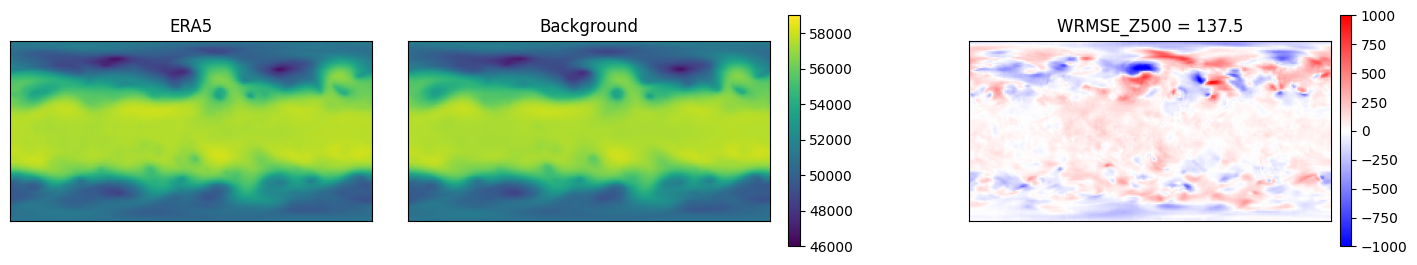

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.1})

vmin_shared, vmax_shared = 46000, 59000
im0 = axes[0].imshow(ERA5_samples[0, 11], vmin=vmin_shared, vmax=vmax_shared, cmap='viridis')
axes[0].set_title('ERA5')
axes[0].set_xticks([])  
axes[0].set_yticks([]) 

im1 = axes[1].imshow(background.cpu()[11], vmin=vmin_shared, vmax=vmax_shared, cmap='viridis')
axes[1].set_title('Background')
axes[1].set_xticks([]) 
axes[1].set_yticks([])  

cbar_shared = fig.colorbar(im1, ax=[axes[0], axes[1]], shrink=0.6, location='right', pad=0.02)

diff = ERA5_samples[0, 11] - background.cpu().numpy()[11]
WRMSE_Z500=WRMSE((ERA5_samples[0:1]), background.cpu())[11]
im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1000, vmax=1000)
axes[2].set_xticks([]) 
axes[2].set_yticks([])  
axes[2].set_title(f'WRMSE_Z500 = {WRMSE_Z500:.1f}')
cbar_diff = fig.colorbar(im2, ax=axes[2], shrink=0.6, location='right', pad=0.02,)

plt.show()


# OSSEs
We use the osbervation mask of GDAS at 2017-01-01 00:00:00 UTC for Observing System Simulation Experiments

In [9]:
mask = GDAS_samples[0,1]
mask01=mask.clone()
mask01[mask>0.1] = 1


# variance of each variable's climatic state, used for generating observation errors
std_layer = torch.from_numpy(np.load('../preprocessing_params/std_layer.npy')).float().reshape(1,-1, 1, 1) 

## Illustration of observations
In OSSEs, we use simulated observation at real observation locations at 2017.1.1 0000 UTC from GDAS.

This study only considers surface and sounding observations

T2 count: 3898.0


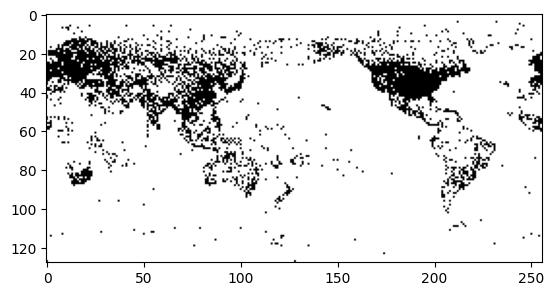

In [10]:
# Surface observation mask (T2)
cmap = ListedColormap(['none', 'black'])  
bounds = [-0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)
plt.imshow(mask01[0, 3].cpu(), cmap=cmap, norm=norm)
print('T2 count:', mask01[0, 3].sum().item())

Z500 count: 449.0


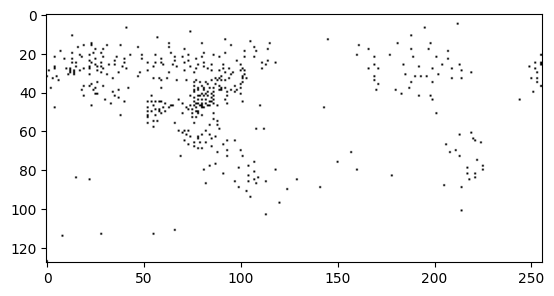

In [11]:
# Sounding observation mask (Z500)
cmap = ListedColormap(['none', 'black'])  
bounds = [-0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)
plt.imshow(mask01[0, 11].cpu(), cmap=cmap, norm=norm)
print('Z500 count:', mask01[0, 11].sum().item())

## Latent Data Assimilation Experiments

window_interval: Time interval between two consecutive observations within an assimilation window (applicable only in L4DVar).

window_size: Number of consecutive observations used in a single assimilation window. 
             If window_size = 1, the method corresponds to L3DVar; if window_size >= 2, it corresponds to L4DVar.
             
DA_step: Number of assimilation windows (i.e., total number of assimilation cycles is DA_step; 
         total number of observation timesteps assimilated = window_size × DA_step).


## L3DVar

Assimilate 4 window of observations at the interval of 6 hours. Then forecast 10 days.

Observation error std: 0.1 * climate std 

In [12]:
window_interval = 1
window_size = 1
DA_step = 4

forecast_day=10

In [13]:
## Control run (without DA)
background_err_list = []
background_list = []
background_field = background.clone().unsqueeze(0).to(device)
for step in range(DA_step+4*forecast_day):
    background_list.append(background_field.detach().cpu().numpy())
    Truth = ERA5_samples[step*window_interval].unsqueeze(0)
    forecast_err = WRMSE(background_field.to(device), Truth.to(device) ).cpu().numpy()
    background_err_list.append(forecast_err)
    
    background_field = forecast_model.integrate(background_field[0], window_interval).unsqueeze(0)

del background_field
torch.cuda.empty_cache()

In [14]:
## Data Assimilation
ana_forecast_err_list = []
ana_forecast_field_list = []

DA_time = []
time_index = 0

ana_forecast_field = background.clone().unsqueeze(0).to(device)

for step in range(DA_step):
    label_list = []
    for window in range(window_size):
        label_list.append(ERA5_samples[time_index + window*window_interval].unsqueeze(0))
    label_list = torch.stack(label_list,axis=0)[:,0]
    
    H = torch.stack([mask01 for i in range(window_size)],axis=0)[:,0]

    # adding observation error
    noise_weight = torch.stack([0.1 * torch.randn_like(mask01) * std_layer  for i in range(window_size)],axis=0)[:,0]
    y = H*(label_list+noise_weight)

    start_clock = time.time()
    analysis_list = DA_system.latent_Var_adam(ana_forecast_field.detach().to(device), y.to(device), H.to(device),  max_step=50, obs_noise=0.1, )
    end_clock = time.time()
    torch.cuda.empty_cache()
    DA_time.append(end_clock-start_clock)

    for j in range(window_size):
        ana_forecast_err = WRMSE(analysis_list[j].unsqueeze(0).to(device), label_list[j].to(device)).cpu().detach().numpy()
        ana_forecast_err_list.append(ana_forecast_err)
        ana_forecast_field_list.append(analysis_list[j].unsqueeze(0).detach().cpu().numpy())
        print(f'Obs Window {step*window_size + j +1}, Analysis WRMSE of Z500: {ana_forecast_err[11]}')
        
    time_index += window_size * window_interval
    ana_forecast_field = analysis_list[0]
    ana_forecast_field = forecast_model.integrate(ana_forecast_field, window_size*window_interval).unsqueeze(0)

    del label_list
    del H
    del y

for i in range(forecast_day*4):
    ana_forecast_field_list.append(ana_forecast_field.detach().cpu().numpy())
    Truth = ERA5_samples[time_index].unsqueeze(0)
    ana_forecast_err = WRMSE(ana_forecast_field.to(device), Truth.to(device) ).cpu().numpy()
    ana_forecast_err_list.append(ana_forecast_err)
    time_index += window_interval
    ana_forecast_field = forecast_model.integrate(ana_forecast_field[0], window_interval).unsqueeze(0)

del ana_forecast_field
torch.cuda.empty_cache()

print(f'Avg DA time for each obs window: {np.sum(DA_time)/(window_size*DA_step):.1f}s')

/home/bingxing2/ailab/fanhang/.conda/envs/pytorch26/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/bingxing2/ailab/fanhang/.conda/envs/pytorch26/lib/python3.10/site-packages/torch/nn/utils/clip_grad.py:69: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /home/bingxing2/apps/package/pytorch/2.5.1-cu121_cp310/pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grads = [p.grad for p in parameters if p.grad is not None]


Obs Window 1, Analysis WRMSE of Z500: 107.44375610351562
Obs Window 2, Analysis WRMSE of Z500: 104.80278778076172
Obs Window 3, Analysis WRMSE of Z500: 109.56184387207031
Obs Window 4, Analysis WRMSE of Z500: 116.59711456298828
Avg DA time for each obs window: 15.6s


### Error At the end of assimilation
Here we also show the location of the Z500 observations.
Areas with obseravtions have lower analysis error.

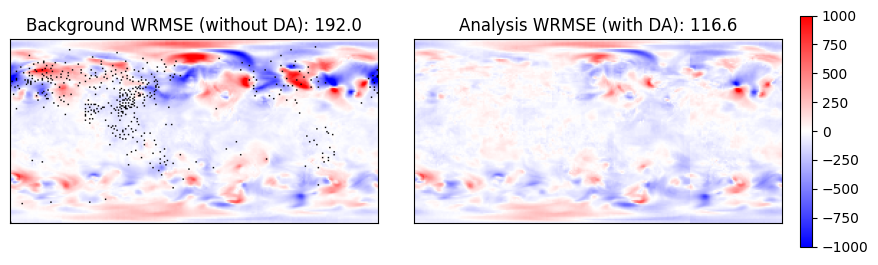

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

vmin_shared, vmax_shared = -1000, 1000

time_step = 3

back_diff = background_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
back_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(background_list[time_step]))[11] 
im0 = axes[0].imshow(back_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[0].set_title(f'Background WRMSE (without DA): {back_WRMSE_Z500:.1f}')
axes[0].set_xticks([])  
axes[0].set_yticks([]) 

cmap = ListedColormap(['none', 'black'])  
bounds = [-0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)
axes[0].imshow(mask01[0, 11].cpu(), cmap=cmap, norm=norm)

ana_diff = ana_forecast_field_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
ana_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(ana_forecast_field_list[time_step]))[11] 
im1 = axes[1].imshow(ana_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[1].set_title(f'Analysis WRMSE (with DA): {ana_WRMSE_Z500:.1f}')
axes[1].set_xticks([])  
axes[1].set_yticks([]) 

cbar_shared = fig.colorbar(im1, ax=[axes[0], axes[1]], shrink=0.6, location='right', pad=0.02)

plt.show()

### Error of 5 day forecast

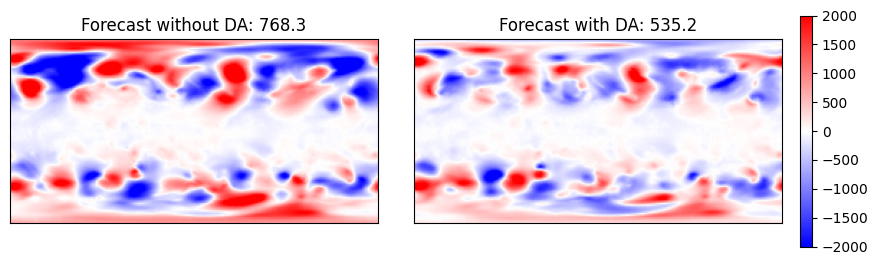

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

vmin_shared, vmax_shared = -2000, 2000

time_step = 3 + 4*5

back_diff = background_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
back_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(background_list[time_step]))[11] 
im0 = axes[0].imshow(back_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[0].set_title(f'Forecast without DA: {back_WRMSE_Z500:.1f}')
axes[0].set_xticks([])  
axes[0].set_yticks([]) 


ana_diff = ana_forecast_field_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
ana_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(ana_forecast_field_list[time_step]))[11] 
im1 = axes[1].imshow(ana_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[1].set_title(f'Forecast with DA: {ana_WRMSE_Z500:.1f}')
axes[1].set_xticks([])  
axes[1].set_yticks([]) 

cbar_shared = fig.colorbar(im1, ax=[axes[0], axes[1]], shrink=0.6, location='right', pad=0.02)

plt.show()

## L4DVar
Experimental design is consistent with L3DVar.

In [17]:
window_interval = 1
window_size = 4
DA_step = 1

forecast_day=10

In [18]:
## Data Assimilation
ana_forecast_err_list = []
ana_forecast_field_list = []

DA_time = []
time_index = 0

ana_forecast_field = background.clone().unsqueeze(0).to(device)

for step in range(DA_step):
    label_list = []
    for window in range(window_size):
        label_list.append(ERA5_samples[time_index + window*window_interval].unsqueeze(0))
    label_list = torch.stack(label_list,axis=0)[:,0]
    
    H = torch.stack([mask01 for i in range(window_size)],axis=0)[:,0]

    # adding observation error
    noise_weight = torch.stack([0.1 * torch.randn_like(mask01) * std_layer  for i in range(window_size)],axis=0)[:,0]
    y = H*(label_list+noise_weight)

    start_clock = time.time()
    analysis_list = DA_system.latent_Var_adam(ana_forecast_field.detach().to(device), y.to(device), H.to(device),  max_step=50, obs_noise=0.1, )
    end_clock = time.time()
    torch.cuda.empty_cache()
    DA_time.append(end_clock-start_clock)

    for j in range(window_size):
        ana_forecast_err = WRMSE(analysis_list[j].unsqueeze(0).to(device), label_list[j].to(device)).cpu().detach().numpy()
        ana_forecast_err_list.append(ana_forecast_err)
        ana_forecast_field_list.append(analysis_list[j].unsqueeze(0).detach().cpu().numpy())
        print(f'Obs Window {step*window_size + j +1}, Analysis WRMSE of Z500: {ana_forecast_err[11]}')
        
    time_index += window_size * window_interval
    ana_forecast_field = analysis_list[0]
    ana_forecast_field = forecast_model.integrate(ana_forecast_field, window_size*window_interval).unsqueeze(0)

    del label_list
    del H
    del y

for i in range(forecast_day*4):
    ana_forecast_field_list.append(ana_forecast_field.detach().cpu().numpy())
    Truth = ERA5_samples[time_index].unsqueeze(0)
    ana_forecast_err = WRMSE(ana_forecast_field.to(device), Truth.to(device) ).cpu().numpy()
    ana_forecast_err_list.append(ana_forecast_err)
    time_index += window_interval
    ana_forecast_field = forecast_model.integrate(ana_forecast_field[0], window_interval).unsqueeze(0)

del ana_forecast_field
torch.cuda.empty_cache()

print(f'Avg DA time for each obs window: {np.sum(DA_time)/(window_size*DA_step):.1f}s')

/home/bingxing2/ailab/fanhang/.conda/envs/pytorch26/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Obs Window 1, Analysis WRMSE of Z500: 86.2966537475586
Obs Window 2, Analysis WRMSE of Z500: 78.15066528320312
Obs Window 3, Analysis WRMSE of Z500: 78.8404769897461
Obs Window 4, Analysis WRMSE of Z500: 82.1157455444336
Avg DA time for each obs window: 17.6s


### Error At the end of assimilation

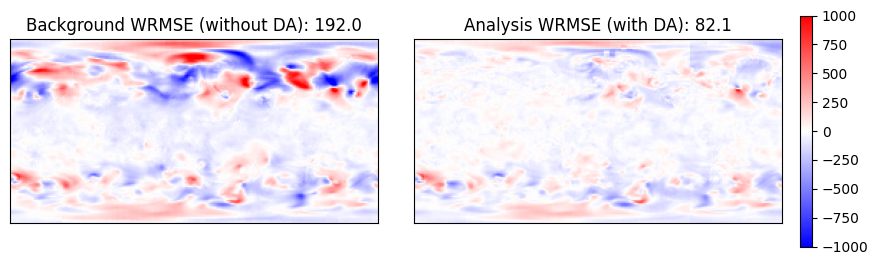

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

vmin_shared, vmax_shared = -1000, 1000

time_step = 3

back_diff = background_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
back_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(background_list[time_step]))[11] 
im0 = axes[0].imshow(back_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[0].set_title(f'Background WRMSE (without DA): {back_WRMSE_Z500:.1f}')
axes[0].set_xticks([])  
axes[0].set_yticks([]) 


ana_diff = ana_forecast_field_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
ana_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(ana_forecast_field_list[time_step]))[11] 
im1 = axes[1].imshow(ana_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[1].set_title(f'Analysis WRMSE (with DA): {ana_WRMSE_Z500:.1f}')
axes[1].set_xticks([])  
axes[1].set_yticks([]) 

cbar_shared = fig.colorbar(im1, ax=[axes[0], axes[1]], shrink=0.6, location='right', pad=0.02)

plt.show()

### Error of 5 day forecast

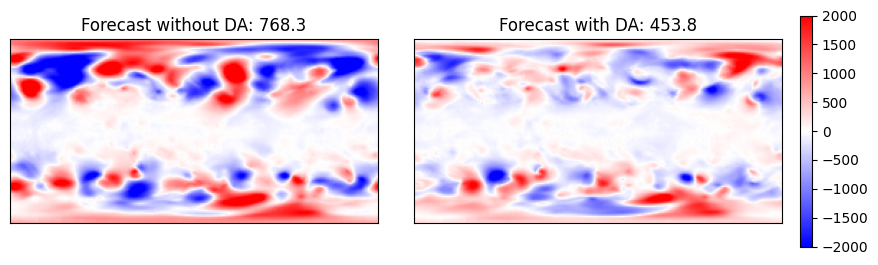

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

vmin_shared, vmax_shared = -2000, 2000

time_step = 3 + 4*5

back_diff = background_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
back_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(background_list[time_step]))[11] 
im0 = axes[0].imshow(back_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[0].set_title(f'Forecast without DA: {back_WRMSE_Z500:.1f}')
axes[0].set_xticks([])  
axes[0].set_yticks([]) 


ana_diff = ana_forecast_field_list[time_step]-ERA5_samples[time_step].unsqueeze(0).numpy()
ana_WRMSE_Z500=WRMSE(ERA5_samples[time_step].unsqueeze(0), torch.from_numpy(ana_forecast_field_list[time_step]))[11] 
im1 = axes[1].imshow(ana_diff[0,11], vmin=vmin_shared, vmax=vmax_shared, cmap='bwr')
axes[1].set_title(f'Forecast with DA: {ana_WRMSE_Z500:.1f}')
axes[1].set_xticks([])  
axes[1].set_yticks([]) 

cbar_shared = fig.colorbar(im1, ax=[axes[0], axes[1]], shrink=0.6, location='right', pad=0.02)

plt.show()